In [1]:
import numpy as np
import plotly.graph_objects as go
from pathlib import Path
import sys
from scipy.spatial import cKDTree
import vtk
import pyvista as pv

In [2]:
sys.path.append(str(Path.cwd().parent))

In [3]:
from comsol_module.comsol_classes import COMSOL_VTU
from comsol_module.helper import calculate_normal
from src.utils import safe_parse_quantity, delete_comsol_fields, map_on_control_mesh, load_pint_data
from scripts.C_map_on_control_mesh import handle_invalid_point_mask

In [4]:
DATA_TYPE = "Test"
ROOT = Path().cwd().parent
vtu_path = ROOT / "data/07/TestOriginal/Test_000.vtu"
comsol_data = COMSOL_VTU(vtu_path)
entropy = np.load(ROOT / f"data/07/{DATA_TYPE}Original/{DATA_TYPE}_entropy_gen_per_vol_thermal.npy")
entropy_num = np.load(ROOT / f"data/07/{DATA_TYPE}Original/{DATA_TYPE}_entropy_gen_number_therm.npy")
field_name = comsol_data.format_field("Temperature", -1)

In [17]:
points = comsol_data.mesh.points
scalar_field = comsol_data.get_point_values("Temperature", -1)
points.shape

(17367, 3)

In [18]:
surf = comsol_data.mesh.compute_cell_sizes()
surf.plot(show_edges=True, scalars='Volume')

Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x10802c200_1&reconnect=auto" class="pyvista…

In [19]:
surf.cell_data['Area']

pyvista_ndarray([0., 0., 0., ..., 0., 0., 0.], shape=(99243,))

In [20]:
tree = cKDTree(points)
k = 15
gradients = np.zeros_like(points)
for i, point in enumerate(points):
    # Find k nearest neighbors (including the point itself)
    distances, indices = tree.query(point, k=k)

    # Relative coordinates of neighbors
    neighbors = points[indices]
    relative_positions = neighbors - point

    # Values of scalar field at neighbors
    values = scalar_field[indices]

    # Build design matrix A: [dx dy dz 1]
    A = np.column_stack((relative_positions, np.ones(k)))

    # Solve least squares: A * coeffs ≈ values
    coeffs, *_ = np.linalg.lstsq(A, values, rcond=None)

    # Gradient is first 3 coefficients: ∂T/∂x, ∂T/∂y, ∂T/∂z
    gradients[i] = coeffs[:3]

In [21]:
comsol_data.mesh.point_data['kd_gradient'] = gradients
comsol_data.mesh.clip(normal = -np.array(calculate_normal(60, 90))).plot(scalars = 'kd_gradient')

Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x179292ae0_2&reconnect=auto" class="pyvista…

In [22]:
# Load or create your vtkUnstructuredGrid
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(vtu_path)
reader.Update()
grid = reader.GetOutput()

# Apply gradient filter
grad_filter = vtk.vtkGradientFilter()
grad_filter.SetInputData(grid)
grad_filter.SetInputScalars(vtk.vtkDataObject.FIELD_ASSOCIATION_POINTS, field_name)  # or FIELD_ASSOCIATION_CELLS
grad_filter.SetResultArrayName("TemperatureGradient")
grad_filter.Update()

# Get output with gradient vector field
output = grad_filter.GetOutput()

In [23]:
mesh = pv.wrap(output)


In [24]:
clipped = mesh.clip(normal = -np.array(calculate_normal(60, 90))).plot(scalars = 'TemperatureGradient')

Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x1785070b0_3&reconnect=auto" class="pyvista…

In [25]:
cleaned = comsol_data.mesh.clean()
cleaned.n_points

17367

In [26]:
deriv  = cleaned.compute_derivative(scalars = field_name)
deriv.clip(normal = -np.array(calculate_normal(60, 90))).plot(scalars = 'gradient')


Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x17d061ca0_4&reconnect=auto" class="pyvista…

In [27]:
deriv = comsol_data.mesh.compute_derivative(scalars = field_name,
                                            gradient = True,
                                            preference = 'point',
                                            progress_bar = True)

Computing Derivative: 100%|██████████[00:00<00:00]


In [36]:
deriv_integrated = deriv.integrate_data()

In [37]:
deriv_integrated

UnstructuredGrid (0x38c49df00)
  N Cells:    1
  N Points:   1
  X Bounds:   2.000e+03, 2.000e+03
  Y Bounds:   2.500e+03, 2.500e+03
  Z Bounds:   -2.000e+03, -2.000e+03
  N Arrays:   368

In [28]:
deriv.point_data['gradient_norm'] = np.linalg.norm(deriv.point_data['gradient'], axis = 1)


In [29]:
deriv.slice(normal = -np.array(calculate_normal(60, 90))).plot(scalars = 'gradient')


Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x3165c7d40_5&reconnect=auto" class="pyvista…

In [30]:
comsol_data.mesh.clip(normal = -np.array(calculate_normal(60, 90)), origin = comsol_data.mesh.center).plot(scalars = field_name)

Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x3165c2060_6&reconnect=auto" class="pyvista…

In [31]:
comsol_data.mesh.point_data['temp'] = entropy[0, -1, :]
normal = -calculate_normal(60, 90)
clipped = comsol_data.mesh.clip(normal = normal, origin = comsol_data.mesh.center)
line1 = pv.Line(-normal*100, normal*100)
center = comsol_data.mesh.center
plane = pv.Plane(direction=normal, center = comsol_data.mesh.center, i_size = 1000, j_size=1000)

# Get two orthogonal vectors in the plane (i and j directions)
# Arbitrary up vector for orientation
up = np.array([0, 0, 1]) if abs(np.dot(normal, [0, 0, 1])) < 0.99 else np.array([1, 0, 0])

# First in-plane direction (i)
i_dir = np.cross(up, normal)
i_dir /= np.linalg.norm(i_dir)

# Second in-plane direction (j)
j_dir = np.cross(normal, i_dir) # along dip
j_dir /= np.linalg.norm(j_dir) # along dip

# Create lines from the center
line_i = pv.Line(center - 4000 * i_dir, center +4000 * i_dir)
line_j = pv.Line(center - 4000 * j_dir, center +4000 * j_dir)

line_translated1 = line_j.copy()
line_translated1 = line_translated1.translate((0, -1000, 0))  # In-place translation

line_translated2 = line_j.copy()
line_translated2 = line_translated2.translate((0, 700, 0))  # In-place translation

# plane_rotated = plane.copy()
# plane_rotated.rotate_vector(angle = 30, vector = normal, point = comsol_data.mesh.center)  # Rotate in-place
plotter = pv.Plotter()
plotter.add_mesh(clipped, scalars = 'temp')
plotter.add_mesh(plane, color="red")
plotter.add_mesh(line_i, color='red', line_width=4, label='i-direction')
# plotter.add_mesh(line_j, color='green', line_width=4, label='j-direction')
plotter.add_mesh(line_translated1, color='green', line_width=4, label='j-direction')
plotter.add_mesh(line_translated2, color='green', line_width=4, label='j-direction')
# plotter.add_mesh(plane_rotated, color="blue")
plotter.show()

Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x31660e750_7&reconnect=auto" class="pyvista…

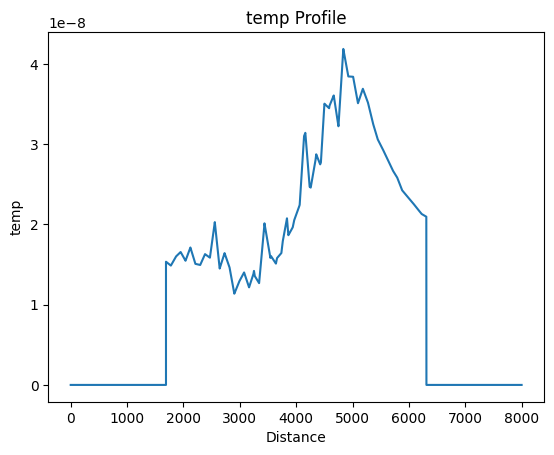

In [32]:
pointa = line_translated2.points[0]
pointb = line_translated2.points[1]
comsol_data.mesh.plot_over_line(pointa, pointb, scalars = 'temp')

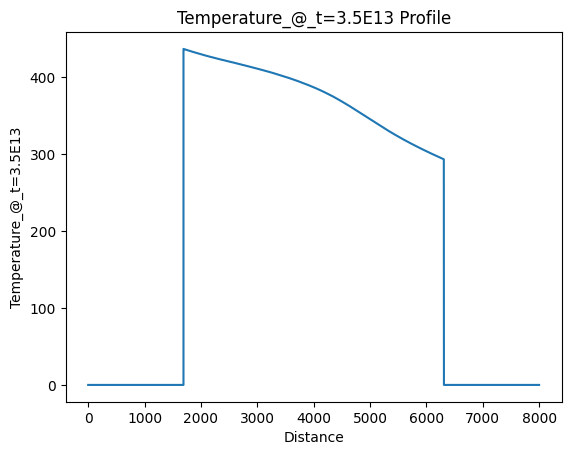

In [33]:
comsol_data.mesh.plot_over_line(pointa, pointb, scalars = field_name)

In [34]:
import pyvista as pv
import numpy as np

# Define the plane
center = np.array([0, 0, 0])
normal = np.array([0.2, 0.5, 1.0])
normal /= np.linalg.norm(normal)

# Create the plane
plane = pv.Plane(center=center, direction=normal, i_size=10, j_size=10)

# Get two orthogonal vectors in the plane (i and j directions)
# Arbitrary up vector for orientation
up = np.array([0, 0, 1]) if abs(np.dot(normal, [0, 0, 1])) < 0.99 else np.array([1, 0, 0])

# First in-plane direction (i)
i_dir = np.cross(up, normal)
i_dir /= np.linalg.norm(i_dir)

# Second in-plane direction (j)
j_dir = np.cross(normal, i_dir)
j_dir /= np.linalg.norm(j_dir)

# Create lines from the center
line_i = pv.Line(center - 5 * i_dir, center + 5 * i_dir)
line_j = pv.Line(center - 5 * j_dir, center + 5 * j_dir)

# Plot
plotter = pv.Plotter()
plotter.add_mesh(plane, color='lightblue', opacity=0.5)
plotter.add_mesh(line_i, color='red', line_width=4, label='i-direction')
plotter.add_mesh(line_j, color='green', line_width=4, label='j-direction')
plotter.add_legend()
plotter.show()


Widget(value='<iframe src="http://localhost:55094/index.html?ui=P_0x316622300_8&reconnect=auto" class="pyvista…

In [35]:
fig = go.Figure()
for data in entropy_num:
    fig.add_trace(go.Scatter(
        x=np.arange(len(data)),
        y=data
    ))
fig.show()